# Calculate ERPs reliability

### Imports

In [1]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression


from scipy.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

In [3]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
random_state = 0

In [4]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600_sonata/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*GNG-(\d+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename, dtype={'Demo_kod': object})
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info, dtype={'Demo_kod': object})
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )      
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    # event_dict = {
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
    #     "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
    #     "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
    #     "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
    #     "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    # }
    
    event_dict = {
        'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10003,
        'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10004,
        'Stimulus/RE*ex*1_n*1_c_2*R': 10005,
        'Stimulus/RE*ex*1_n*2_c_1*R': 10006,
        'Stimulus/RE*ex*2_n*1_c_1*R': 10007,
        'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10008,
        'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10009,
        'Stimulus/RE*ex*2_n*2_c_2*R': 10010,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10003, 10004, 10008, 10009],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10005, 10006, 10007, 10010],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = False
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
    
    return epochs_ar

#### Read the data

In [7]:
def change_column_names(data_df):
    columns_dict = {
        "16-Rumination Full Scale": "RRQ", # mean
        "05-DASS-21 Anxiety scale": "DASS-21 Anx", # mean
        ###
        "05-DASS-21 Stress scale": "DASS-21 Stress", # mean
        "05-DASS-21 Depression scale": "DASS-21 Dep", # mean
        "04-STAI Trait MEAN": "STAI-T_M", # mean
        "04-STAI STATE 1-2 DIFFERENCE": "STAI-S Diff", # sum
        "number_error" : "uninhibited response", # sum
        "number_inhibited" : "inhibited response", # sum
        ###
        "04-STAI Trait SUM": "STAI-T", # sum
        "07-BIS": "BIS", # mean
        "14-Obsessive-Compulsive WASHING": "WASH", # mean
        "14-Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "14-Obsessive-Compulsive HOARDING": "HOARD", # mean
        "14-Obsessive-Compulsive ORDERING": "ORD", # mean
        "14-Obsessive-Compulsive CHECKING": "CHECK", # mean
        "14-Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        # "14-Obsessive-Compulsive FULL": "OCI-R",
        "18-Thought Suppression Inventory": "WBSI", # mean
        "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "06-Self-Esteem Scale_SES Rosenberga": "SES", # mean
        "07-BAS Dzialanie": 'BAS_D', # mean
        "07-BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean
        "07-BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean
        "22-Nonforgiveness - Full Scale": 'NONFOR',
        "27-Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "03-SP (Punishment Sensitivity)": 'PUN', # sum
        "03-SR (Reward Sensitivity)": 'REW', # sum
        "15-Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "15-Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "15-Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        "17-Perfectionism CMDA": 'CMDA', # mean
        "17-Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "19-Guilt sensitivity": 'G_SE', # mean
        "31-NFC Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "31-NFC Preferowanie przewidywalności-FULL": 'PRED', # mean
        "32-High standards from Maximization Full Scale" : 'STAND',   # mean
        "Wiek": "Age",
        "Płeć": "Sex",
        "Ręczność": "Handness",    

        #######
        "Rumination Full Scale": "RRQ",
        "DASS-21 Anxiety scale 0-SUM": "DASS-21 Anx", # sum
        "DASS-21 Stress scale 0-SUM": "DASS-21 Stress", # sum
        "DASS-21 Depression scale 0-SUM": "DASS-21 Dep", # sum
        "number_error": "uninhibited response", # sum
        "number_inhibited":  "inhibited response", # sum
        "STAI STATE 1-2 DIFFERENCE": "STAI-S Diff", # sum
        ###
        "STAI Trait SUM": "STAI-T", # sum
        "BIS": "BIS", # mean
        "Obsessive-Compulsive WASHING": "WASH", # mean
        "Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "Obsessive-Compulsive HOARDING": "HOARD", # mean
        "Obsessive-Compulsive ORDERING": "ORD", # mean
        "Obsessive-Compulsive CHECKING": "CHECK", # mean
        "Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        # "14-Obsessive-Compulsive FULL": "OCI-R",
        "Thought Suppression Inventory": "WBSI", # mean
        "Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "Self-Esteem Scale_SES Rosenberga MEAN": "SES", # mean
        "BAS Dzialanie": 'BAS_D', # mean # drive
        "BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean # fun seeking
        "BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean # responsivness
        # "22-Nonforgiveness - Full Scale": 'NONFOR',
        "Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "SP (Punishment Sensitivity)": 'PUN', # sum
        "SR (Reward Sensitivity)": 'REW', # sum
        "Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        # "17-Perfectionism CMDA": 'CMDA',
        "Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "Guilt sensitivity": 'G_SE', # mean
        "Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "Preferowanie przewidywalności-FULL": 'PRED', # mean
        "High standards from Maximization Full Scale" : 'STAND',   # mean
    }

    data_df = data_df.rename(columns=columns_dict)
    return data_df

- read Opus train data

In [8]:
# %%capture
df_name = "GNG_autoreject_3_5"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_opus_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    # save loaded data into a pickle file
    epochs_train_opus_df.to_pickle("../data/" + epochs_train_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [9]:
epochs_train_opus_df.shape

(110, 188)

In [10]:
epochs_train_opus_df['STAI-T'] = epochs_train_opus_df['STAI-T'].apply(lambda x: x/20)

- read Sonata train data

In [11]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_stai"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_sonata_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    # save loaded data into a pickle file
    epochs_train_sonata_df.to_pickle("../data/" + epochs_train_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [12]:
epochs_train_sonata_df.shape

(150, 110)

Refine some data from questionnaries to reconcile data from two datasets

In [13]:
epochs_train_sonata_df.loc[epochs_train_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [14]:
# normalize DASS-21 subscales scores to mean
epochs_train_sonata_df['DASS-21 Stress'] = epochs_train_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Anx'] = epochs_train_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Dep'] = epochs_train_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [15]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_train_sonata_df['STAI-T'] = epochs_train_sonata_df['STAI-T'].apply(lambda x: x/20)

In [16]:
# fill missing value in STAI-S Diff score
epochs_train_sonata_df.loc[epochs_train_sonata_df['STAI-S Diff'] == 'None', 'STAI-S Diff'] = None
epochs_train_sonata_df['STAI-S Diff'] = np.array(epochs_train_sonata_df['STAI-S Diff'].to_list()).astype(np.float) 

In [17]:
epochs_train_sonata_df['STAI-S Diff'] = epochs_train_sonata_df['STAI-S Diff'].fillna(epochs_train_sonata_df['STAI-S Diff'].mean())

#### Read data for external testing

- read Opus test

In [18]:
# %%capture
df_name = "GNG_autoreject_3_5_test_performance"
pickled_data_filename = "../data/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_opus_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    # save loaded data into a pickle file
    epochs_test_opus_df.to_pickle("../data/" + epochs_test_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [19]:
epochs_test_opus_df.shape

(45, 164)

In [20]:
epochs_test_opus_df['STAI-T'] = epochs_test_opus_df['STAI-T'].apply(lambda x: x/20)

- read Sonata test

In [21]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_test_stai"
pickled_data_filename = "../data/" + df_name + ".pkl"
# info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_sonata_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    # save loaded data into a pickle file
    epochs_test_sonata_df.to_pickle("../data/" + epochs_test_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [22]:
epochs_test_sonata_df.shape

(67, 110)

Refine some data from questionnaries to reconcile data from two datasets

In [23]:
epochs_test_sonata_df.loc[epochs_test_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [24]:
# normalize DASS-21 subscales scores to mean
epochs_test_sonata_df['DASS-21 Stress'] = epochs_test_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Anx'] = epochs_test_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Dep'] = epochs_test_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [25]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_test_sonata_df['STAI-T'] = epochs_test_sonata_df['STAI-T'].apply(lambda x: x/20)

In [26]:
# fill missing value in STAI-S Diff score
epochs_test_sonata_df.loc[epochs_test_sonata_df['STAI-S Diff'] == 'None', 'STAI-S Diff'] = None
epochs_test_sonata_df['STAI-S Diff'] = np.array(epochs_test_sonata_df['STAI-S Diff'].to_list()).astype(np.float) 

In [27]:
epochs_test_sonata_df['STAI-S Diff'] = epochs_test_sonata_df['STAI-S Diff'].fillna(epochs_test_sonata_df['STAI-S Diff'].mean())

## Merge dataframes

In [28]:
opus_columns_list = epochs_train_opus_df.columns.to_list()
sonata_columns_list = epochs_train_sonata_df.columns.to_list()

columns = list(set(opus_columns_list) & set(sonata_columns_list))

In [29]:
epochs_train_sonata_df = epochs_train_sonata_df[columns]
epochs_train_opus_df = epochs_train_opus_df[columns]

epochs_test_sonata_df = epochs_test_sonata_df[columns]
epochs_test_opus_df = epochs_test_opus_df[columns]

Create train and test data

In [30]:
epochs_train_df = pd.concat([epochs_train_sonata_df, epochs_train_opus_df], ignore_index=True)
epochs_test_df = pd.concat([epochs_test_sonata_df, epochs_test_opus_df], ignore_index=True)

#### Chose dataset

In [46]:
test = True
dataset = 'test' if test else 'train'

In [47]:
epochs_df = epochs_train_df if not test else epochs_test_df

In [48]:
epochs_df.shape

(112, 40)

## Within subject variability

In [49]:
within_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            # ("lowpass", BandpassFilter()),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ('extract_epoch_data', ExtractDataEpochs(condition='correct_response')),
            ("mean_amplitude", AverageSignal()),
    ])

    # for each person in dataset
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        # print(data['epoch'].to_list())
        id_ = data['id'].to_list()
        # print(id_)
        personal_X = ern_pipeline.fit_transform(data) * 1000000
        personal_X = personal_X.reshape(-1,1)
        
        # print(personal_X.shape)

        personal_variance = np.std(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_df = pd.concat([within_df, data], ignore_index = True)

In [50]:
within_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,024,11.948887,199
1,Fz,187,8.419082,217
2,Fz,132,6.665801,217
3,Fz,077,9.306183,212
4,Fz,154,8.433907,220


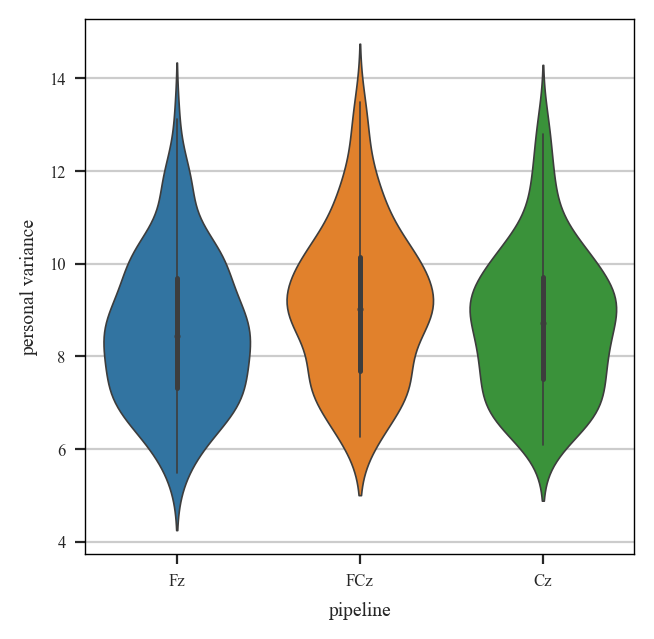

In [51]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [52]:
within_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  8.705334  1.544599  6.086099  7.514953  8.713913   
FCz                  112.0  9.095754  1.614691  6.259669  7.687173  9.013420   
Fz                   112.0  8.538255  1.576405  5.475016  7.310540  8.432758   

                               num_trials                                      \
                75%        max      count        mean       std   min     25%   
pipeline                                                                        
Cz         9.716545  13.087483      112.0  211.107143  17.98666  82.0  207.75   
FCz       10.151729  13.489623      112.0  211.107143  17.98666  82.0  207.75   
Fz         9.697707  13.113342      112.0  211.107143  17.98666  82.0  207.75   

                               
            50%    75%    max  
pipeline                       
Cz        217.0  221.0  224.0  
FCz       217.0  221.0  224.0  
Fz        217.0  221.0  224.0

### Between-subject variability

In [53]:
between_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            # ("lowpass", BandpassFilter()),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ("average", Evoked(condition='correct_response')),
            ('extract_epoch_data', ExtractData()),
            ("mean_amplitude", AverageSignal()),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy) * 1000000
    X = X.reshape(-1,1)
    variance = np.std(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_df = pd.concat([between_df, data], ignore_index = True)

(112, 1, 27)
(112, 1, 27)
(112, 1, 27)


<AxesSubplot: xlabel='values', ylabel='pipeline'>

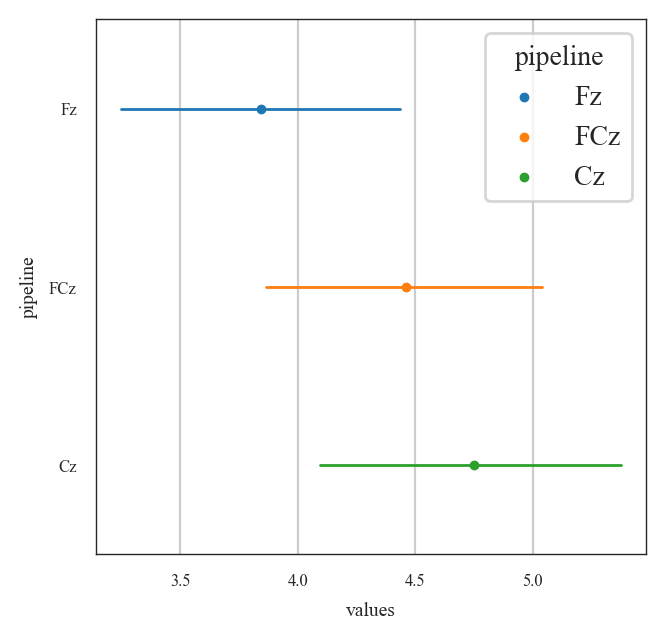

In [54]:
sns.pointplot(
    data = between_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [55]:
between_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          112.0  4.752396  8.921703e-16  4.752396  4.752396  4.752396   
FCz         112.0  4.460793  8.921703e-16  4.460793  4.460793  4.460793   
Fz          112.0  3.841325  1.338255e-15  3.841325  3.841325  3.841325   

                             values                                          \
               75%       max  count      mean       std       min       25%   
pipeline                                                                      
Cz        4.752396  4.752396  112.0  5.667489  4.773755 -5.423843  2.353717   
FCz       4.460793  4.460793  112.0  2.975115  4.480842 -7.763752 -0.304444   
Fz        3.841325  3.841325  112.0  0.714454  3.858590 -8.058798 -1.923590   

                                         
               50%       75%        max  
pipeline                                 
Cz        5.820807  8.775012  19.549499  
FCz       2.680547  6.324853  16.622474  
Fz        0.520878  2.820583  13.158445

## Internal Consistency

In [63]:
consistency_df = pd.DataFrame()

In [64]:
for pipeline in between_df['pipeline'].unique().tolist():
    
    between_std = np.std(np.array(between_df.loc[between_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({'pipeline' : [pipeline],
                'internal_variance' : [internal_consistency],
        })
    
        consistency_df = pd.concat([consistency_df, data], ignore_index=True)

3.8413251814587124
4.460793387172164
4.752395732068132


In [65]:
consistency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  0.983847  0.005601  0.965775  0.980798  0.984156   
FCz                  112.0  0.980098  0.006749  0.960265  0.976117  0.980891   
Fz                   112.0  0.976400  0.008350  0.949910  0.970574  0.977164   

                              
               75%       max  
pipeline                      
Cz        0.987915  0.992499  
FCz       0.985521  0.990779  
Fz        0.983307  0.990767

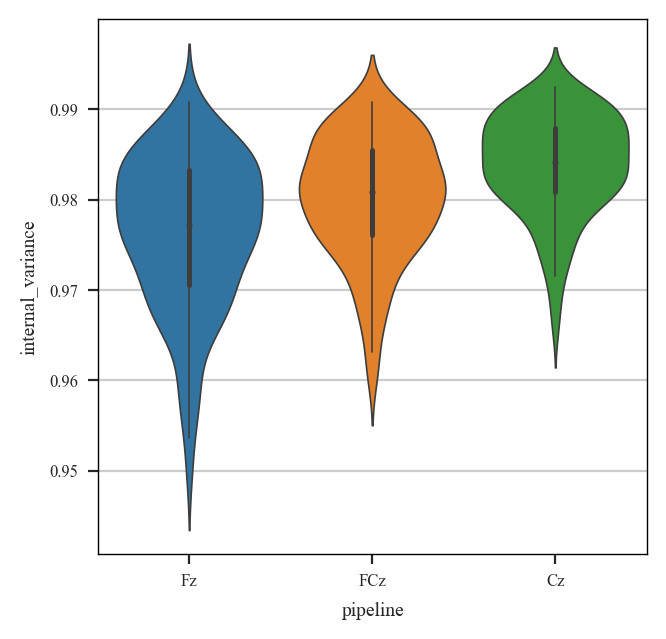

In [59]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')